In [29]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import os
import zipfile

from sklearn.feature_selection import RFE, SelectKBest, f_classif, VarianceThreshold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score ,roc_auc_score
from concurrent.futures import ProcessPoolExecutor
from collections import Counter

In [30]:
df_temp_yes = pd.read_csv('Mutation_299_Yes_40scores_2936.txt',delimiter='\t')

In [31]:
# df_temp_yes

In [32]:
def split_data(df, target_column, test_size=0.2, random_state=None,downsample=False):
    # Convert 'YES'/'NO' to binary
    df[target_column] = df[target_column].map({'YES': 1, 'NO': 0})
    
    # Splitting each class independently
    df_yes = df[df[target_column] == 1]
    df_no = df[df[target_column] == 0]
    
    if downsample:
        # df_no = df_no.sample(n=len(df_yes),random_state=random_state)
        df_yes = df_yes.sample(n=len(df_no),random_state=random_state)
    
    # print(f"NO values : {len(df_no)} , Yes Values : {len(df_yes)} ") 
    
    train_yes_X, test_yes_X, train_yes_y, test_yes_y = train_test_split(
        df_yes.loc[:, df_yes.columns != target_column], df_yes[target_column], 
        test_size=test_size, random_state=random_state)
    
    train_no_X, test_no_X, train_no_y, test_no_y = train_test_split(
        df_no.loc[:, df_no.columns != target_column], df_no[target_column], 
        test_size=test_size, random_state=random_state)
    
    # Combine the splits from both classes
    train_X = pd.concat([train_yes_X, train_no_X])
    train_y = pd.concat([train_yes_y, train_no_y])
    test_X = pd.concat([test_yes_X, test_no_X])
    test_y = pd.concat([test_yes_y, test_no_y])
    
    # Shuffle the combined splits as they are currently sorted by class
    train_X, train_y = shuffle(train_X, train_y, random_state=random_state)
    test_X, test_y = shuffle(test_X, test_y, random_state=random_state)
    
    # Create the dictionary of dictionaries
    data = {
        'train': {'X': train_X, 'y': train_y},
        'test': {'X': test_X, 'y': test_y}
    }
    
    data['train']['X'] = data['train']['X'].set_index('Chromosome_Start_Ref_Alt').to_numpy()
    
    data['test']['X'] = data['test']['X'].set_index('Chromosome_Start_Ref_Alt').to_numpy()
    
    
    data['train']['y'] = data['train']['y'].to_numpy() 
    data['test']['y'] = data['test']['y'].to_numpy()
    
    return data

In [47]:
class Feature_classifiers:
    def __init__(self):
        
        self.models = {
            'LogisticRegression': LogisticRegression(class_weight='balanced',max_iter=1000),
            'SVC': SVC(kernel='linear'), 
            'RandomForestClassifier': RandomForestClassifier()
        }
        self.results = {}
        self.model_coefficients = {}
        
    def get_feature_importances(self, model_name):
        if model_name != 'RandomForestClassifier':
            raise ValueError("This method is only applicable for RandomForestClassifier.")

        feature_importances = self.model_coefficients.get(model_name, None)
        if feature_importances is None:
            raise ValueError("Feature importances not found. Ensure the model has been fitted.")
        return feature_importances

    def apply_rfe(self, model, X_train, y_train, n_features=5):
        rfe = RFE(estimator=model, n_features_to_select=n_features)
        rfe.fit(X_train, y_train)
        return rfe.ranking_

    def apply_feature_selection(self, n_features=5):
        X_train, y_train = self.data['train']['X'], self.data['train']['y']
        feature_rankings = {}

        for name, model in self.models.items():
            feature_rankings[name] = {}
            feature_rankings[name]['RFE'] = self.apply_rfe(model, X_train, y_train, n_features=n_features)

        self.feature_rankings = feature_rankings

    def generate_reports(self):
        report_df = pd.DataFrame(self.results).T
        return report_df
       
    def create_feature_ranking_df(self, model_name, feature_names):
        if model_name not in self.feature_rankings:
            raise ValueError(f"Model {model_name} not found in feature rankings.")

        log_reg_results = self.feature_rankings[model_name]

        df = pd.DataFrame(index=feature_names)
        df['RFE'] = log_reg_results['RFE']
        df['Importance'] = self.model_coefficients.get(model_name, 'N/A')
        return df

    def model_stability_evaluation(self, model_name, n_runs=100):
        if model_name not in self.models:
            raise ValueError(f"Model {model_name} not found.")

        # Load the static df_yes only once
        df_yes = pd.read_csv('raw_data/label_YES/Mutation_299_Yes_40scores_2936.txt', delimiter='\t')
        chromosome_ref_name = df_yes['Chromosome_Start_Ref_Alt']
        # for pre-processing 9 removing string value (labels) 
        del df_yes['Chromosome_Start_Ref_Alt']
        
        # replacing '.' values that represents missing values with np.nan
        df_yes.replace('.', np.nan, inplace=True)
        # converting all existing numbers (which are string) to numeric values 
        df_yes = df_yes.apply(pd.to_numeric, errors='coerce')
        #replaceing the 'NaN' or missing values with the mean of the particular feature
        df_yes.fillna(df_yes.mean(), inplace=True)
        df_yes['Status'] = 'YES'
        df_yes['Chromosome_Start_Ref_Alt'] = chromosome_ref_name
        self.feature_names = list(df_yes.columns[:-2])
        
        metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'auc': []}
        coefficients = {}
        feature_importances = []
        cdf = {}

        for run_id in range(1, n_runs + 1):
            # Load a new df_no(with labels NO) for each run
            df_no_path = f'./raw_data/label_NO/Iteration{run_id}_2936-No.txt'
            df_no = pd.read_csv(df_no_path, delimiter='\t')
            temp1 = df_no['Chromosome_Start_Ref_Alt']
            del df_no['Chromosome_Start_Ref_Alt']
            df_no.replace('.', np.nan, inplace=True)
            df_no = df_no.apply(pd.to_numeric, errors='coerce')
            df_no.fillna(df_no.mean(), inplace=True)
            df_no['Status'] = 'NO'
            df_no['Chromosome_Start_Ref_Alt'] = temp1

            # Combine df_yes and df_no for the current iteration
            df_combined = pd.concat([df_yes, df_no], axis=0)

            # Assuming `split_data` properly splits your dataset
            temp_data = split_data(df_combined, 'Status', random_state=run_id)
            X_train, y_train = temp_data['train']['X'], temp_data['train']['y']
            X_test, y_test = temp_data['test']['X'], temp_data['test']['y']

            model = self.models[model_name]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Collect metrics
            run_metrics = {
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred, average='weighted'),
                'recall': recall_score(y_test, y_pred, average='weighted'),
                'f1_score': f1_score(y_test, y_pred, average='weighted'),
                'auc': roc_auc_score(y_test, y_pred, average='weighted')
            }

            for key in metrics:
                metrics[key].append(run_metrics[key])

            # Collect feature importances(Random Forest) or coefficients(Logistic Regression and SVM)
            importance = model.coef_[0] if hasattr(model, 'coef_') else model.feature_importances_ if hasattr(model, 'feature_importances_') else None

            # Feature selection methods
            rfe_support = self.apply_rfe(model, X_train, y_train, n_features=5)

            # Update cdf with feature selection results
            cdf[run_id] = {
                'RFE': rfe_support,
                'Importance': importance
            }

            if importance is not None:
                if 'coef_' not in coefficients:
                    coefficients['coef_'] = [importance] if model_name in ['LogisticRegression', 'SVC'] else [importance]
                elif model_name == 'RandomForestClassifier':
                    feature_importances.append(importance)
                else:
                    coefficients['coef_'].append(importance)
 

        # Convert lists of metrics to DataFrames for visualization and analysis
        metrics_df = pd.DataFrame(metrics)
        coefficients_df = pd.DataFrame(coefficients['coef_']) if 'coef_' in coefficients else None
        feature_importances_df = pd.DataFrame(feature_importances) if feature_importances else None

        # Plotting the metrics
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=metrics_df)
        plt.title(f'Model Stability Evaluation for {model_name}')
        plt.ylabel('Scores')
        plt.xlabel('Metrics')
        plt.show()

        return metrics_df, coefficients_df, feature_importances_df, cdf

    def aggregate_feature_selection_results(self, cdf):
        num_indexes_imp = len(cdf[1]['Importance'])
        max_values = [-float('inf')] * num_indexes_imp
        min_values = [float('inf')] * num_indexes_imp

        num_indexes_rfe = len(cdf[1]['RFE'])
        index_counters = [Counter() for _ in range(num_indexes_rfe)]

        # Process each run
        for run in cdf.values():
            # Update for 'Importance'
            importance = run['Importance']
            for idx, value in enumerate(importance):
                max_values[idx] = max(max_values[idx], value)
                min_values[idx] = min(min_values[idx], value)

            # Update for 'RFE'
            rfe = run['RFE']
            for idx, value in enumerate(rfe):
                index_counters[idx][value] += 1

        # Finalize results
        ranges = [(np.round(min_val, 2), np.round(max_val, 2)) for max_val, min_val in zip(max_values, min_values)]
        most_frequent_values = [counter.most_common(1)[0][0] for counter in index_counters]

        # Create a DataFrame with feature names as the index
        FFdf = pd.DataFrame(index=self.feature_names)

        # Add data to the DataFrame
        FFdf['Importance Range'] = pd.Series(ranges, index=self.feature_names[:len(ranges)])
        FFdf['RFE Most Frequent Rank'] = pd.Series(most_frequent_values, index=self.feature_names[:len(most_frequent_values)])

        return FFdf

In [48]:
fc = Feature_classifiers()

In [49]:
# feature_names = list(fc.DFS.columns[:-2])

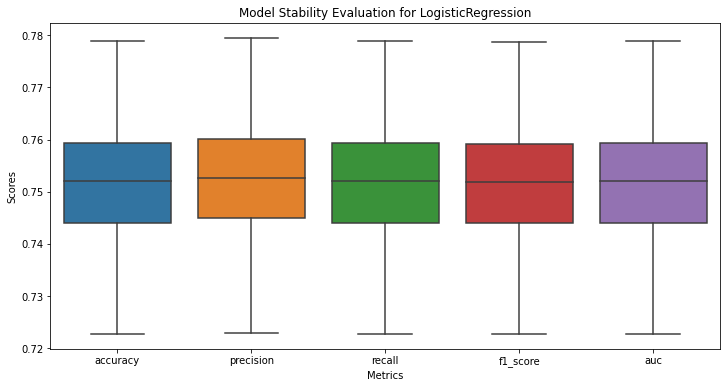

In [55]:
data_LR , coef_LR , fidf_LR , cdf_LR = fc.model_stability_evaluation('LogisticRegression',n_runs=100)

In [56]:
fc.aggregate_feature_selection_results(cdf_LR)

,Importance Range,RFE Most Frequent Rank
SIFT_converted_rankscore,"(0.09, 0.88)",19
SIFT4G_converted_rankscore,"(-0.45, 0.39)",33
Polyphen2_HDIV_rankscore,"(-1.25, 0.4)",29
Polyphen2_HVAR_rankscore,"(0.22, 1.49)",16
LRT_converted_rankscore,"(-1.63, -0.76)",6
MutationTaster_converted_rankscore,"(-1.01, -0.03)",21
MutationAssessor_rankscore,"(-0.8, 0.18)",20
FATHMM_converted_rankscore,"(0.46, 1.47)",5
PROVEAN_converted_rankscore,"(-1.98, -1.18)",1
VEST4_rankscore,"(-0.91, 0.09)",24


In [54]:
# cdf_LR